# Predict Fantasy Points - Model Development

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, learning_curve, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

# Prepare Data for Model Development

In [2]:
season_22_23 = pd.read_csv('../data/processed/Season(2022-23)_cleaned.csv')
season_23_24 = pd.read_csv('../data/processed/Season(2023-24)_cleaned.csv')

In [3]:
season_22_23['Season'] = '2022-23'
season_23_24['Season'] = '2023-24'

season_22_23.head()

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season
0,2022-10-18,tyrese maxey,Philadelphia 76ers,38:11,8,16,0.500,2,5,0.400,...,13.7,-6,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20002546,30.2,2022-23
1,2022-10-18,james harden,Philadelphia 76ers,37:17,9,14,0.643,5,9,0.556,...,31.9,1,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20000544,52.1,2022-23
2,2022-10-18,joel embiid,Philadelphia 76ers,37:16,9,18,0.500,1,6,0.167,...,17.7,-13,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20000726,48.5,2022-23
3,2022-10-18,tobias harris,Philadelphia 76ers,34:14,7,14,0.500,3,6,0.500,...,13.4,-1,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20000676,29.4,2022-23
4,2022-10-18,p.j. tucker,Philadelphia 76ers,33:01,3,5,0.600,0,2,0.000,...,3.6,-6,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20000856,11.8,2022-23


In [4]:
def get_unique_ids(df):
  unique_ids = df.groupby('Name')['id'].nunique()
  players_with_multiple_ids = unique_ids[unique_ids > 1]
  return players_with_multiple_ids

season_22_23_ids = get_unique_ids(season_22_23)
season_23_24_ids = get_unique_ids(season_23_24)

print(season_22_23_ids) 
print(season_23_24_ids) 

Series([], Name: id, dtype: int64)
Series([], Name: id, dtype: int64)


Calculate rolling window averages of every 2 games for each player. This will add a new column that represents each of these 2 game averages across the datasets.

In [5]:
stats_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel']

def calculate_rolling_avg(df):
  df.sort_values(by=['id', 'Date'], inplace=True)
  grouped = df.groupby('id')
  for column in stats_columns:
    rolling_means = grouped[column].rolling(window=2).mean().shift(1)
    rolling_means = rolling_means.reset_index(level=0, drop=True)
    df[f'{column}_2game_avg'] = rolling_means
  df.loc[df.groupby('id').head(1).index, [f'{column}_2game_avg' for column in stats_columns]] = pd.NA
  return df

season_22_23 = calculate_rolling_avg(season_22_23)
season_23_24 = calculate_rolling_avg(season_23_24)

df = pd.concat([season_22_23, season_23_24], ignore_index=True)


In [7]:
df = pd.concat([season_22_23, season_23_24], ignore_index=True)

In [8]:
player_id = 20003022
player_data = df[df['id'] == player_id][['Date', 'FG', 'FG_2game_avg', 'PTS', 'PTS_2game_avg']]
player_data.head(10)

,Date,FG,FG_2game_avg,PTS,PTS_2game_avg
27738,2023-02-15,0,NaN,2,NaN
53362,2023-10-28,0,NaN,0,NaN
53363,2023-10-30,0,NaN,0,NaN
53364,2023-11-01,0,0.0,0,0.0
53365,2023-11-02,0,0.0,0,0.0
53366,2023-11-05,0,0.0,0,0.0
53367,2023-11-06,5,0.0,15,0.0
53368,2023-11-08,1,2.5,2,7.5
53369,2023-11-10,1,3.0,10,8.5
53370,2023-11-17,2,1.0,10,6.0


In [9]:
player_ids_in_both_seasons = df[df['Date'] == '2023-06-12']['id'].unique()
player_ids_in_both_seasons_2023_24 = df[df['Date'] > '2023-10-24']['id'].unique()
player_ids_in_both_seasons = np.intersect1d(player_ids_in_both_seasons, player_ids_in_both_seasons_2023_24)

selected_player_id = player_ids_in_both_seasons[0]

In [10]:
selected_player_data = df[df['id'] == selected_player_id]

print("End of 2022-23 season:")
end_of_2022_23 = selected_player_data[(selected_player_data['Date'] > '2023-05-01') & (selected_player_data['Date'] <= '2023-06-12')]
print(end_of_2022_23[['Date', 'PTS', 'PTS_2game_avg']])

print("\nBeginning of 2023-24 season:")
beginning_of_2023_24 = selected_player_data[(selected_player_data['Date'] >= '2023-10-24') & (selected_player_data['Date'] <= '2023-11-30')]
print(beginning_of_2023_24[['Date', 'PTS', 'PTS_2game_avg']])


End of 2022-23 season:
           Date  PTS  PTS_2game_avg
405  2023-05-02    6           14.0
406  2023-05-06   14           12.0
407  2023-05-08   15           10.0
408  2023-05-10    9           14.5
409  2023-05-12   11           12.0
410  2023-05-17   15           10.0
411  2023-05-19    0           13.0
412  2023-05-21    7            7.5
413  2023-05-23    5            3.5
414  2023-05-25    5            6.0
415  2023-05-27    8            5.0
416  2023-05-29    7            6.5
417  2023-06-01   11            7.5
418  2023-06-04    9            9.0
419  2023-06-07    9           10.0
420  2023-06-09   13            9.0
421  2023-06-12   12           11.0

Beginning of 2023-24 season:
             Date  PTS  PTS_2game_avg
28007  2023-10-25    0            NaN
28008  2023-10-27   13            NaN
28009  2023-10-28    3            6.5
28010  2023-10-30    8            8.0
28011  2023-11-01    6            5.5
28012  2023-11-03    3            7.0
28013  2023-11-06    5           

In [11]:
print(df[df['Season'] == '2022-23']['Date'].max())
print(df[df['Season'] == '2023-24']['Date'].min())

2023-06-12
2023-10-24


In [12]:
pd.set_option('display.max_columns', None)
df.nunique().to_frame().T

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
0,420,661,30,2825,25,43,226,14,24,83,24,28,91,16,21,30,23,8,11,13,7,67,530,97,30,2639,30,2,4,661,814,2,41,68,4520,21,38,1965,36,43,1032,21,34,45,37,13,16,17,13,104,5848,145,7339


In [14]:
pd.options.display.float_format = '{:.2f}'.format
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FG,55970.00,3.95,3.35,0.00,1.00,3.00,6.00,25.00
FGA,55970.00,8.34,6.20,0.00,3.00,7.00,12.00,47.00
FG%,55970.00,0.44,0.26,0.00,0.29,0.46,0.59,1.00
3P,55970.00,1.18,1.49,0.00,0.00,1.00,2.00,13.00
3PA,55970.00,3.26,3.04,0.00,1.00,3.00,5.00,23.00
3P%,55970.00,0.26,0.29,0.00,0.00,0.20,0.50,1.00
FT,55970.00,1.66,2.39,0.00,0.00,1.00,2.00,24.00
FTA,55970.00,2.12,2.86,0.00,0.00,1.00,3.00,32.00
FT%,55970.00,0.42,0.44,0.00,0.00,0.44,1.00,1.00
ORB,55970.00,0.99,1.36,0.00,0.00,1.00,1.00,15.00


In [26]:
# Convert MM:SS format to total minutes as float
def convert_mp_to_minutes(mp_str):
  if isinstance(mp_str, str):
    minutes, seconds = map(int, mp_str.split(':'))
    return minutes + seconds / 60.0
  return 0

In [31]:
df['MP'] = df['MP'].apply(convert_mp_to_minutes)
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes.to_frame()

,0
Date,datetime64[ns]
Name,object
Team,object
MP,int64
FG,int64
FGA,int64
FG%,float64
3P,int64
3PA,int64
3P%,float64


In [30]:
df.head()

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
0,2022-10-19,bradley beal,Washington Wizards,0,9,17,0.53,2,7,0.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-21,bradley beal,Washington Wizards,0,9,14,0.64,1,2,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-23,bradley beal,Washington Wizards,0,11,16,0.69,0,1,0.00,...,3.00,7.00,0.00,1.50,4.00,2.00,21.00,16.20,6.00,35.60
3,2022-10-25,bradley beal,Washington Wizards,0,4,9,0.44,1,4,0.25,...,2.50,6.50,1.00,1.00,5.50,2.50,23.00,16.80,-0.50,36.25
4,2022-10-28,bradley beal,Washington Wizards,0,11,18,0.61,2,5,0.40,...,4.00,5.50,1.00,0.00,4.00,2.50,20.00,15.30,0.00,32.05


# Model Development

In [23]:
# Use one-hot encoding for the categorical variables
categorical_columns = ['Team', 'TeamAbbr', 'Opponent', 'GameType', 'Season', 'Name']

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_columns])
enc_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_features, columns=enc_feature_names)
df_encoded = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)
df_encoded.head()

,Date,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,GameLink,Home,id,fpts_fanduel,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Hornets,Team_Chicago Bulls,Team_Cleveland Cavaliers,Team_Dallas Mavericks,Team_Denver Nuggets,Team_Detroit Pistons,Team_Golden State Warriors,Team_Houston Rockets,Team_Indiana Pacers,Team_Los Angeles Clippers,Team_Los Angeles Lakers,Team_Memphis Grizzlies,Team_Miami Heat,Team_Milwaukee Bucks,Team_Minnesota Timberwolves,Team_New Orleans Pelicans,Team_New York Knicks,Team_Oklahoma City Thunder,Team_Orlando Magic,Team_Philadelphia 76ers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Wizards,TeamAbbr_BOS,TeamAbbr_BRK,TeamAbbr_CHI,TeamAbbr_CHO,TeamAbbr_CLE,TeamAbbr_DAL,TeamAbbr_DEN,TeamAbbr_DET,TeamAbbr_GSW,TeamAbbr_HOU,TeamAbbr_IND,TeamAbbr_LAC,TeamAbbr_LAL,TeamAbbr_MEM,TeamAbbr_MIA,TeamAbbr_MIL,TeamAbbr_MIN,TeamAbbr_NOP,TeamAbbr_NYK,TeamAbbr_OKC,TeamAbbr_ORL,TeamAbbr_PHI,TeamAbbr_PHO,TeamAbbr_POR,TeamAbbr_SAC,TeamAbbr_SAS,TeamAbbr_TOR,TeamAbbr_UTA,TeamAbbr_WAS,Opponent_Boston Celtics,Opponent_Brooklyn Nets,Opponent_Charlotte Hornets,Opponent_Chicago Bulls,Opponent_Cleveland Cavaliers,Opponent_Dallas Mavericks,Opponent_Denver Nuggets,Opponent_Detroit Pistons,Opponent_Golden State Warriors,Opponent_Houston Rockets,Opponent_Indiana Pacers,Opponent_Los Angeles Clippers,Opponent_Los Angeles Lakers,Opponent_Memphis Grizzlies,Opponent_Miami Heat,Opponent_Milwaukee Bucks,Opponent_Minnesota Timberwolves,Opponent_New Orleans Pelicans,Opponent_New York Knicks,Opponent_Oklahoma City Thunder,Opponent_Orlando Magic,Opponent_Philadelphia 76ers,Opponent_Phoenix Suns,Opponent_Portland Trail Blazers,Opponent_Sacramento Kings,Opponent_San Antonio Spurs,Opponent_Toronto Raptors,Opponent_Utah Jazz,Opponent_Washington Wizards,GameType_Play-In,GameType_Playoffs,GameType_Season,Season_2023-24,Name_a.j. lawson,Name_aaron gordon,Name_aaron holiday,Name_aaron nesmith,Name_aaron wiggins,Name_adam flagler,Name_adama sanogo,Name_admiral schofield,Name_aj griffin,Name_al horford,Name_alec burks,Name_aleksej pokusevski,Name_alex caruso,Name_alex fudge,Name_alex len,Name_alize johnson,Name_alondes williams,Name_alperen sengun,Name_amari bailey,Name_amen thompson,Name_amir coffey,Name_andre drummond,Name_andre iguodala,Name_andre jackson jr.,Name_andrew funk,Name_andrew nembhard,Name_andrew wiggins,Name_anfernee simons,Name_anthony black,Name_anthony davis,Name_anthony edwards,Name_anthony gill,Name_anthony lamb,Name_armoni brooks,Name_ashton hagans,Name_ausar thompson,Name_austin reaves,Name_austin rivers,Name_ayo dosunmu,Name_bam adebayo,Name_ben sheppard,Name_ben simmons,Name_bennedict mathurin,Name_bilal coulibaly,Name_bismack biyombo,Name_blake griffin,Name_blake wesley,Name_boban marjanovic,Name_bobby portis,Name_bogdan bogdanovic,Name_bojan bogdanovic,Name_bol bol,Name_bones hyland,Name_bradley beal,Name_brandin podziemski,Name_brandon boston jr.,Name_brandon clarke,Name_brandon ingram,Name_brandon miller,Name_brandon williams,Name_braxton key,Name_brice sensabaugh,Name_brook lopez,Name_bruce brown,Name_bruno fernando,Name_bryce mcgowens,Name_bryn forbes,Name_buddy boeheim,Name_buddy hield,Name_cade cunningham,Name_caleb houstan,Name_caleb martin,Name_cam reddish,Name_cam thomas,Name_cam whitmore,Name_cameron johnson,Name_cameron payne,Name_caris levert,Name_carlik jones,Name_cason wallace,Name_cedi osman,Name_chance comanche,Name_charles bassey,Name_charlie brown jr.,Name_chet holmgren,Name_chima moneke,Name_chimezie metu,Name_chris boucher,Name_chris duarte,Name_chris livingston,Name_chris paul,Name_c

### Linear Regression #1

#### Split data

In [25]:
# split the data into 80-10-10 train, val, and test split
X = df_encoded.drop('fpts_fanduel', axis=1)
y = df_encoded['fpts_fanduel']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (44776, 797), Validation set: (5597, 797), Test set: (5597, 797)


#### Train Model

In [26]:
# Drop date column since it is not numeric
imputer = SimpleImputer(strategy='mean')

X_train = X_train.drop(columns=['Date', 'GameLink'])
X_train['MP'] = X_train['MP'].apply(convert_mp_to_minutes)

X_val = X_val.drop(columns=['Date', 'GameLink'])
X_val['MP'] = X_val['MP'].apply(convert_mp_to_minutes)

# replace missing values with mean of each column
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)


model = LinearRegression()
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print(f'Validation R^2 Score: {r2_score(y_val, y_val_pred)}')
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred)}')
print(f'Root Mean Squared Error (RMSE): {mean_squared_error(y_val, y_val_pred, squared=False)}')

Validation R^2 Score: -3.82782629944482
Mean Absolute Error (MAE): 0.849400666692075
Mean Squared Error (MSE): 1143.46287948046
Root Mean Squared Error (RMSE): 33.81512796782618


#### Evaluate Model

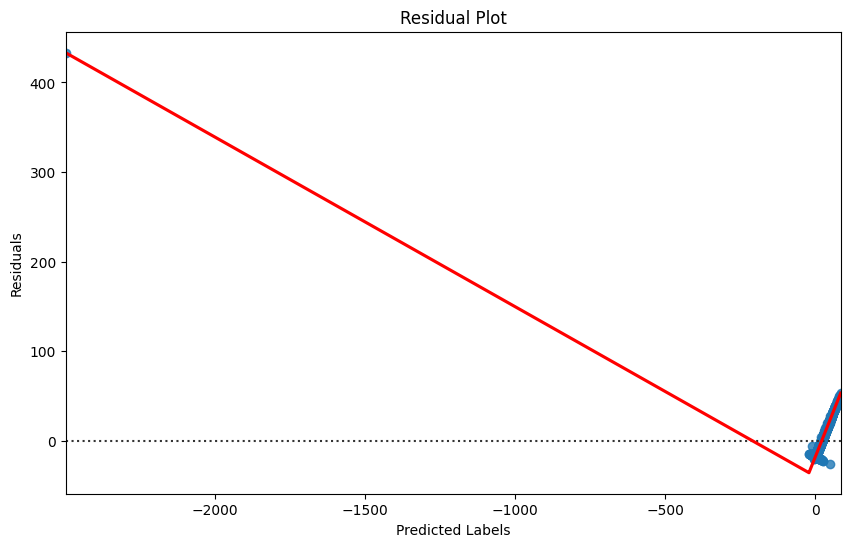

In [27]:
# Residuals Plots
residuals = y_val - y_val_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_val_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Labels')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

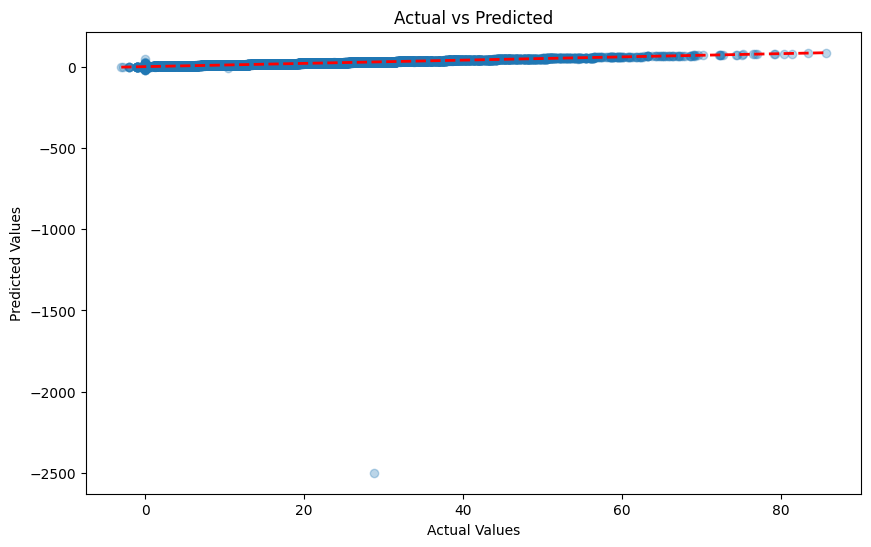

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

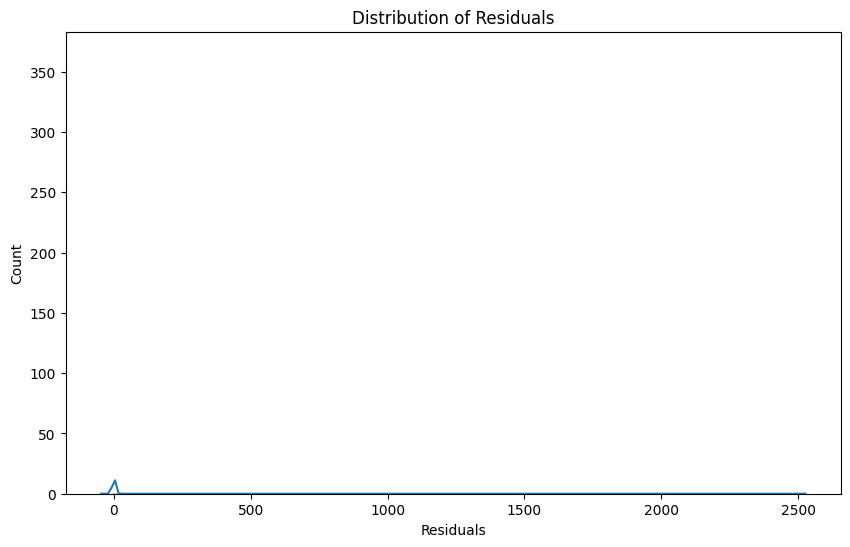

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

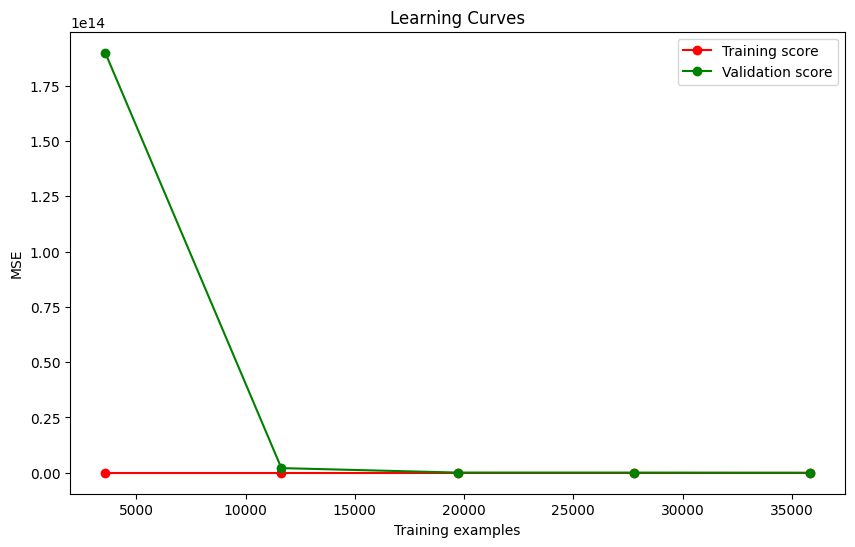

In [30]:
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=5,
                                                      scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5)
                                                      )

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

### Linear Regression #2

In [ ]:
df = df.drop(columns=['id', 'GameLink'])